<h1>Import Library

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
from transformers import BertTokenizer

c:\Users\DELL\.conda\envs\tf-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1> Load Dataset

In [3]:
df = pd.read_csv('../data/raw/synthetic_vehicle_complaints.csv')

In [4]:
df.head()

,VehicleType,Brand,Year,Mileage,Complaint,DamageLevel,ServiceType,Price,FirstAidSolution
0,Car,Suzuki,2020,62385,Oli bocor,Low,Oil Change,241006,1. Matikan mesin\n2. Periksa bagian bawah kend...
1,Motorcycle,Kawasaki,2009,30677,Oli bocor,Medium,Oil Change,400116,1. Matikan mesin\n2. Periksa bagian bawah kend...
2,Car,Honda,2018,69984,Ban bocor,Low,Tire Service,115206,1. Pinggirkan kendaraan\n2. Gunakan ban serep\...
3,Motorcycle,Honda,2021,148584,Radiator bocor,Medium,Cooling System Repair,363701,1. Matikan mesin\n2. Tambahkan air sementara\n...
4,Car,Nissan,2023,27836,Kopling slip,Low,Transmission Repair,172572,1. Hindari perpindahan gigi mendadak\n2. Kuran...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       1000 non-null   object
 1   Brand             1000 non-null   object
 2   Year              1000 non-null   int64 
 3   Mileage           1000 non-null   int64 
 4   Complaint         1000 non-null   object
 5   DamageLevel       1000 non-null   object
 6   ServiceType       1000 non-null   object
 7   Price             1000 non-null   int64 
 8   FirstAidSolution  1000 non-null   object
dtypes: int64(3), object(6)
memory usage: 70.4+ KB


In [6]:
df.isnull().sum()

VehicleType         0
Brand               0
Year                0
Mileage             0
Complaint           0
DamageLevel         0
ServiceType         0
Price               0
FirstAidSolution    0
dtype: int64

In [7]:
df["ServiceType"].value_counts()

ServiceType
Electrical Repair        146
Transmission Repair      144
Suspension Repair         85
AC Repair                 77
Tire Service              75
Power Steering Repair     73
Battery Replacement       70
Cooling System Repair     69
Brake Service             68
Oil Change                66
Engine Repair             65
General Checkup           62
Name: count, dtype: int64

In [8]:
df["Complaint"].sample(5, random_state=42)

521            AC tidak dingin
737             Radiator bocor
740               Baterai soak
660             Suspensi keras
411    Starter tidak berfungsi
Name: Complaint, dtype: object

<h1> Pre Processing

<h2>Text Cleaning

In [9]:
def basic_cleaning(text):
    text = str(text).lower() #lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) #hapus angka dan simbol
    text = re.sub(r'\s+', ' ', text).strip() # hapus spasi ganda
    return text

df["CleanComplaint"] = df["Complaint"].apply(basic_cleaning)
df[["Complaint", "CleanComplaint"]].head()

,Complaint,CleanComplaint
0,Oli bocor,oli bocor
1,Oli bocor,oli bocor
2,Ban bocor,ban bocor
3,Radiator bocor,radiator bocor
4,Kopling slip,kopling slip


<h2>Stemming

In [10]:
# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Terapkan stemming
df["StemmedComplaint"] = df["CleanComplaint"].apply(stemmer.stem)
df[["CleanComplaint", "StemmedComplaint"]].head()

,CleanComplaint,StemmedComplaint
0,oli bocor,oli bocor
1,oli bocor,oli bocor
2,ban bocor,ban bocor
3,radiator bocor,radiator bocor
4,kopling slip,kopling slip


In [11]:
le = LabelEncoder()
df["Label"] = le.fit_transform(df["ServiceType"])

# Simpan label encoder jika perlu untuk prediksi nanti
joblib.dump(le, "label_encoder.pkl")

# Lihat mapping label
dict(zip(le.classes_, le.transform(le.classes_)))

{'AC Repair': np.int64(0),
 'Battery Replacement': np.int64(1),
 'Brake Service': np.int64(2),
 'Cooling System Repair': np.int64(3),
 'Electrical Repair': np.int64(4),
 'Engine Repair': np.int64(5),
 'General Checkup': np.int64(6),
 'Oil Change': np.int64(7),
 'Power Steering Repair': np.int64(8),
 'Suspension Repair': np.int64(9),
 'Tire Service': np.int64(10),
 'Transmission Repair': np.int64(11)}

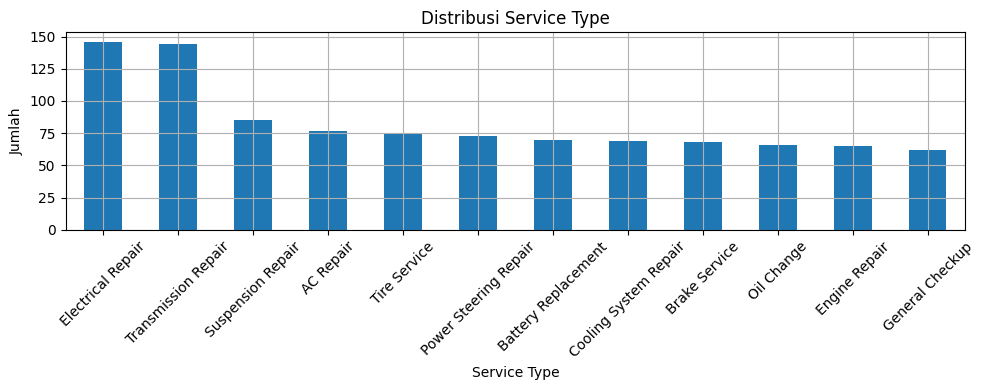

In [12]:
df["ServiceType"].value_counts().plot(kind="bar", figsize=(10,4), title="Distribusi Service Type")
plt.xlabel("Service Type")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

<h1> Tokenisasi

In [13]:
# Load tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Tokenisasi keluhan yang sudah di-stemming
texts = df["StemmedComplaint"].tolist()
labels = df["Label"].tolist()

# Tokenisasi batch
encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)